# Heat equation: analytic vs Crank–Nicolson FD vs py-pde FD

In [4]:
#   1) Final solution overlay (analytic, CN, py-pde)
#   2) Pointwise error |CN - analytic|
#   3) Pointwise error |py-pde - analytic|

!pip install py-pde

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as _trapezoid
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from pde import DiffusionPDE, ScalarField, CartesianGrid
from scipy.sparse.linalg import gmres


def trapezoid(y, x, axis=-1):
    if _trapezoid is not None:
        return _trapezoid(y, x, axis=axis)
    return np.trapz(y, x, axis=axis)


# 1) Analytic via sine series
def heat_analytic(u0_func, alpha=1.0, L=1.0, x=None, t=0.1, N=200):
    if x is None:
        x = np.linspace(0, L, 501)
    xs = np.linspace(0, L, 20001)
    f = u0_func(xs)
    n = np.arange(1, N + 1)
    S = np.sin(np.pi * np.outer(xs / L, n))
    bn = (2.0 / L) * trapezoid(f[:, None] * S, xs, axis=0)
    Sx = np.sin(np.pi * np.outer(x / L, n))
    decay = np.exp(-alpha * (np.pi * n / L) ** 2 * t)
    u = (Sx * (bn * decay)).sum(axis=1)
    return x, u


# 2) Finite Difference: Crank–Nicolson
def heat1d_cn(u0_func, alpha=1.0, L=1.0, T=0.1, nx=401, dt=1e-4, bc0=0.0, bcL=0.0):

    x = np.linspace(0, L, nx) # space discretization
    dx = x[1] - x[0] # time increment
    k = alpha * dt / dx**2
    m = nx - 2

    # Creating the triadiagonal matrices A, B

    A = diags([(-k)*np.ones(m-1), (2+2*k)*np.ones(m), (-k)*np.ones(m-1)],
              offsets=[-1, 0, 1], format="csc")

    B = diags([(k)*np.ones(m-1), (2-2*k)*np.ones(m), (k)*np.ones(m-1)],
              offsets=[-1, 0, 1], format="csr")

    u = u0_func(x).astype(float) # intial condition
    u[0], u[-1] = bc0, bcL
    u_int = u[1:-1].copy() # creating vector that will store the interior nodes for which we will solve for
    nt = int(np.ceil(T / dt)) # number of steps

    b_edge = np.zeros(m)

    # Directly setting the boundary values
    b_edge[0]  = k * bc0
    b_edge[-1] = k * bcL

    # Solving the system per time step using the GMRES algorithm

    for _ in range(nt):

      rhs = B @ u_int + b_edge

      u_int, _ = gmres(A, rhs, x0=u_int, restart=100,
                          maxiter=1000, atol=1e-12)


    # Writing the final values of the interior nodes
    u[1:-1] = u_int

    return x, u


# 3) Library FD: py-pde
def heat_py_pde(u0_func, alpha=1.0, L=1.0, T=0.1, nx=401, dt=None, bc0=0.0, bcL=0.0):

    grid = CartesianGrid([[0.0, L]], [nx])
    x = grid.axes_coords[0]
    state = ScalarField(grid, data=u0_func(x))
    eq = DiffusionPDE(diffusivity=alpha, bc={"x-": {"value": bc0}, "x+": {"value": bcL}})

    dx = x[1] - x[0]
    dt_max = 0.5 * dx * dx / alpha
    dt_use = min(dt, 0.45*dt_max) if dt is not None else 0.45*dt_max

    result = eq.solve(state, t_range=T, dt=dt_use)
    return x, np.asarray(result.data)

In [7]:
L, alpha, T = 1.0, 1.0, 0.3
u0 = lambda x: np.sin(np.pi * x / L)
nx = 401
xg = np.linspace(0, L, nx)
dt = 5e-5

# Compute solutions
xa, ua = heat_analytic(u0, alpha=alpha, L=L, x=xg, t=T, N=300)

xf, uf = heat1d_cn(u0, alpha=alpha, L=L, T=T, nx=nx, dt=dt, bc0=0.0, bcL=0.0)

xl, ul = heat_py_pde(u0, alpha=alpha, L=L, T=T, nx=nx, dt=dt, bc0=0.0, bcL=0.0)

  0%|          | 0/0.3 [00:00<?, ?it/s]

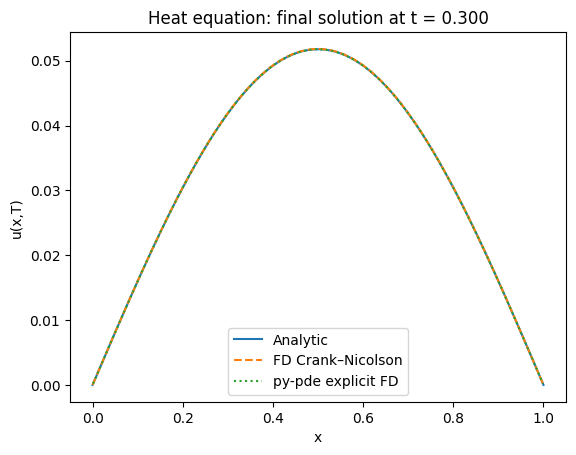

In [8]:
plt.figure()
plt.plot(xa, ua, label="Analytic")
plt.plot(xf, uf, label="FD Crank–Nicolson", linestyle="--")
plt.plot(xl, ul, label="py-pde explicit FD", linestyle=":")
plt.title("Heat equation: final solution at t = {:.3f}".format(T))
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.legend()
plt.show()